In [1]:
import os
import pandas as pd
import pickle
import numpy as np
import dissertation.tools.utils as utils
import librosa
import matplotlib.pyplot as plt
import matplotlib as mpl
import subprocess
import glob
from keras.models import model_from_json
from speech2ult.tools.transform_ultrasound import transform_ultrasound

In [2]:
def load_model(path):
    model_weights = path[:-10] + 'weights.h5'
    with open(path, "r") as json_file:
        loaded_model_json = json_file.read()
    model = model_from_json(loaded_model_json)
    # load weight into model
    model.load_weights(model_weights)
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [3]:
class TestFile:
    def __init__(self, basename, ult, wav, sr, dlc_ult):
        self.basename = basename
        self.ult = ult
        self.wav = wav
        self.sr = sr
        self.dlc = dlc_ult
        self.aud_scalar = None
        self.ult_scalar = None
        self.dlc_scalar = None
        self.aud_feat = None
        self.window = None
        self.lstm = None
        self.get_butter()
        self.get_med()
        self.get_bothfilt()

    def get_butter(self):
        """apply butterworth filter to each column (body part)"""
        filtered = np.empty_like(self.dlc)
        fc = 10  # Cut-off frequency of the filter
        w = fc / (60 / 2)  # Normalize the frequency
        b, a = signal.butter(5, w, 'low')

        for col in range(self.dlc.shape[1]):
            filtered[:, col] = signal.filtfilt(b, a, self.dlc[:, col])

        self.butter = filtered

    def get_med(self):
        """apply median filter to each column (body part)"""
        filtered = np.empty_like(self.dlc)
        for col in range(self.dlc.shape[1]):
            filtered[:, col] = signal.medfilt(self.dlc[:, col], 7)

        self.medfilt = filtered

    def get_bothfilt(self):
        """apply median filter to each column (body part)"""
        filtered = np.empty_like(self.dlc)
        for col in range(self.dlc.shape[1]):
            filtered[:, col] = signal.medfilt(self.butter[:, col], 7)

        self.bothfilt = filtered

In [4]:
def transfrom(ult, colour=0):
    ult_t = transform_ultrasound(ult, background_colour=colour, num_scanlines=64,
                             size_scanline=128, angle=0.025,
                             zero_offset=30, pixels_per_mm=0.5)

    # get rid of border
    ult_t = ult_t[:, 50:-50, 10:-10]
    return ult_t

In [5]:
 def make_vid(img_dir, name, type='avi', out_dir=None):
    if not out_dir:
        out_dir = img_dir
    subprocess.call(
        ["ffmpeg", "-y", "-r", "60",
         "-i", img_dir + "/%07d.jpg", "-vcodec", "mpeg4", "-qscale", "5", "-r",
         "60", out_dir + f"/{name}.{type}"])

In [6]:
testfiles = glob.glob('speech2ult/predictions/test_data/*testfile*')
testfile_path = testfiles[1]

In [7]:
# load in testfile
with open(testfile_path, 'rb') as file:
    testfile = pickle.load(file)

In [8]:
testfile.transform = transfrom(testfile.ult)

In [539]:
model_paths = 'speech2ult/predictions/models/new_tests/ffn_w'
model_list = glob.glob(model_paths + '/**/*.json')
model_names = [f'{os.path.basename(model_paths)}_{os.path.basename(os.path.dirname(i))}' for i in model_list]
model_type = 'ffn'
pred_list = []

In [540]:
for path in model_list:
    model = load_model(path)
    model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              201000    
                                                                 
 dense_1 (Dense)             (None, 1000)              1001000   
                                                                 
 dense_2 (Dense)             (None, 1000)              1001000   
                                                                 
 dense_3 (Dense)             (None, 1000)              1001000   
                                                                 
 dense_4 (Dense)             (None, 1000)              1001000   
                                                                 
 dense_5 (Dense)             (None, 8192)              8200192   
                                                                 
Total params: 12,405,192
Trainable params: 12,405,192
No

In [95]:
# for ultrasounds

for path in model_list:
    model = load_model(path)

    if model_type == 'ffn':
        pred_ult = model.predict(testfile.aud_feat, verbose=0)
    elif model_type == 'window':
        pred_ult = model.predict(testfile.window, verbose=0)
    elif model_type == 'lstm':
        pred_ult = model.predict(testfile.lstm, verbose=0)

    pred_trans = testfile.ult_scalar.inverse_transform(pred_ult)
    pred_trans = transfrom(pred_trans.reshape(-1, 64, 128))

    pred_list.append(pred_trans)

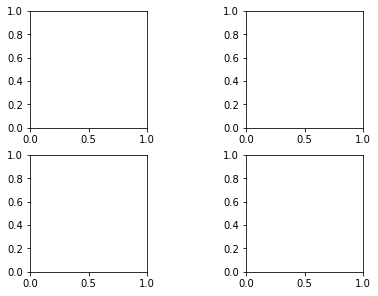

In [96]:
save_dir = os.path.join(model_paths, 'pred1')
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

max_pred = np.max(pred_list)
max_true = np.max(testfile.transform)

# if i want a grid
grid = [model_names[:2], [model_names[2], 'true']]
fig, ax = plt.subplot_mosaic(grid, layout = 'constrained')

for f in range(testfile.ult.shape[0]):
    for i, name in enumerate(model_names):
        ax[name].set_title(name)
        ax[name].axis('off')
        ax[name].imshow(pred_list[i][f].T, aspect='equal', origin='lower', cmap='gray', vmax=max_pred, vmin=0)

    ax['true'].set_title('True Ultrasound')
    ax['true'].axis('off')
    ax['true'].imshow(testfile.transform[f].T, aspect='equal', origin='lower', cmap='gray', vmin=0, vmax=max_true)

    plt.savefig(save_dir + "/%07d.jpg" % f, dpi=150)
    for i in ax:
        ax[i].clear()

In [97]:
make_vid(save_dir, 'lstm')

ffmpeg version 3.2.4 Copyright (c) 2000-2017 the FFmpeg developers
  built with Apple LLVM version 6.1.0 (clang-602.0.53) (based on LLVM 3.6.0svn)
  configuration: --prefix=/Users/travis/miniconda3/conda-bld/ffmpeg_1510333912089/_b_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_pl --disable-doc --enable-shared --enable-static --extra-cflags='-Wall -g -m64 -pipe -O3 -march=x86-64 -fPIC -I/Users/travis/miniconda3/conda-bld/ffmpeg_1510333912089/_b_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_pl/include' --extra-cxxflags='=-Wall -g -m64 -pipe -O3 -march=x86-64 -fPIC' --extra-libs='-L/Users/travis/miniconda3/conda-bld/ffmpeg_1510333912089/_b_env_placehold_placehold_placehold_placehold_placehold_place

In [ ]:
# ********DLC STUFF*********

In [328]:
testfile_path = testfiles[1]
# load in testfile
with open(testfile_path, 'rb') as file:
    testfile = pickle.load(file)

In [329]:
testfile.ult.shape

(102, 64, 128)

In [330]:
# for one dlc
model_paths = 'speech2ult/predictions/models/dlc_tests/ffn_dlc'
model_list = glob.glob(model_paths + '/**/*.json')
model_names = [f'{os.path.basename(model_paths)}_{os.path.basename(os.path.dirname(i))}' for i in model_list]
model_type = 'ffn' #ffn, window
filter_type = None # both, butter, median
pred_list = []
pred_xylist = []

In [9]:
filter = {
    'both': testfile.bothfilt,
    'butter': testfile.butter,
    'median': testfile.medfilt
}

In [332]:
# get acutal scalars
model_scalar_path = glob.glob(os.path.join(model_paths, 'data', 'PARAM_DICTS*.pickle'))[0]
with open(model_scalar_path, 'rb') as file:
    dlc_params, aud_params = pickle.load(file)
    filt_scalar = dlc_params['scalar']

In [333]:
for path in model_list:
    model = load_model(path)

    if model_type == 'ffn':
        pred_dlc = model.predict(testfile.aud_feat, verbose=0)
    elif model_type == 'window':
        pred_dlc = model.predict(testfile.window, verbose=0)

    # need to use proper scalar
    # pred_dlc = testfile.dlc_scalar.inverse_transform(pred_dlc)
    pred_dlc = filt_scalar.inverse_transform(pred_dlc)
    dlc_xy = pred_dlc.reshape((-1, 11, 2))

    pred_list.append(pred_dlc)
    pred_xylist.append(dlc_xy)

In [10]:
testfile.xy = testfile.dlc.reshape((-1, 11, 2))
testfile.both_xy = testfile.bothfilt.reshape((-1, 11, 2))
testfile.med_xy = testfile.medfilt.reshape((-1, 11, 2))
testfile.butter_xy = testfile.butter.reshape((-1, 11, 2))

In [11]:
testfile.col_names = ['vallecula_x', 'vallecula_y', 'tongueRoot1_x', 'tongueRoot1_y',
       'tongueRoot2_x', 'tongueRoot2_y', 'tongueBody1_x', 'tongueBody1_y',
       'tongueBody2_x', 'tongueBody2_y', 'tongueDorsum1_x', 'tongueDorsum1_y',
       'tongueDorsum2_x', 'tongueDorsum2_y', 'tongueBlade1_x',
       'tongueBlade1_y', 'tongueBlade2_x', 'tongueBlade2_y', 'tongueTip1_x',
       'tongueTip1_y', 'tongueTip2_x', 'tongueTip2_y']

In [336]:
save_dir = os.path.join(model_paths, 'pred1')
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
plot_dir = os.path.join(save_dir, 'plots')
if not os.path.exists(plot_dir):
    os.mkdir(plot_dir)

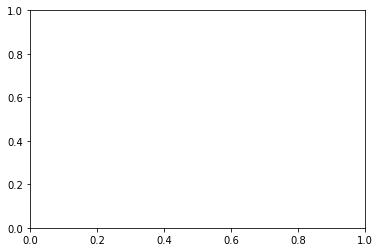

In [337]:
# visualize each body part on graph with filters
fig, ax = plt.subplots()
for col in range(len(testfile.col_names)):
    ax.set_title(testfile.col_names[col])
    ax.set_xlabel('Time in frames (60fps)')
    ax.set_ylabel('Pixle position')
    xdata = np.arange(len(testfile.dlc[:, col]))
    # plot for each model
    for i in range(len(pred_list)):
        ax.plot(xdata, pred_list[i][:, col], label=model_names[i], ls='--', linewidth = 1)
    # plot the true dlc
    ax.plot(xdata, testfile.dlc[:, col], label='True DLC', color='r')
    # and specified filter
    if filter_type != None:
        ax.plot(xdata, filter[filter_type][:, col], label=filter_type)

    ax.legend()
    plt.savefig(plot_dir + f"/{testfile.col_names[col]}.jpg", dpi=150)
    ax.clear()

In [338]:
grid = [[model_names[0], 'butter_filter'],
        [model_names[1], 'median_filter'],
        ['True DLC', 'both_filters']]

In [314]:
grid_dict = {
    model_names[0]: pred_xylist[0],
    model_names[1]: pred_xylist[1],
    'butter_filter': testfile.butter_xy,
    'median_filter': testfile.med_xy,
    'True DLC': testfile.xy,
    'both_filters': testfile.both_xy
}

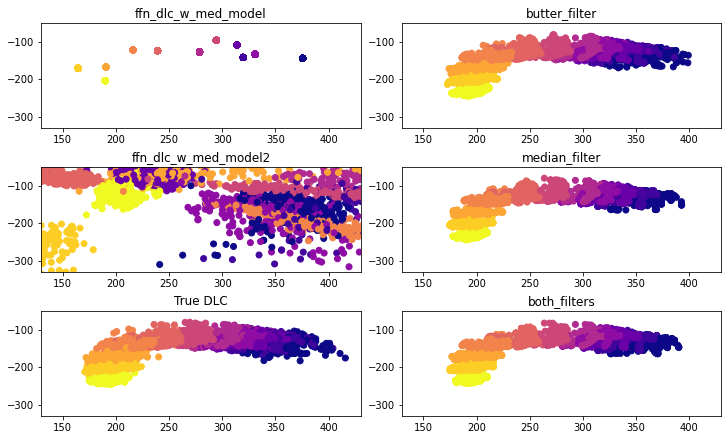

In [316]:
# visualize all together with filter
colors = np.array([100, 90, 80, 70, 60, 50, 40, 30, 20, 10, 0])

fig, ax = plt.subplot_mosaic(grid, figsize=(10,6), layout='constrained')

for frame in range(testfile.dlc.shape[0]):
# for frame in range(7,8):
    for i in ax:
        ax[i].set_title(f'{i}')
        ax[i].set_xlim([130, 430])
        ax[i].set_ylim([-330, -50])
        ax[i].scatter(grid_dict[i][frame, :, 0], -grid_dict[i][frame, :, 1], c=colors, cmap='plasma')

# plt.savefig(save_dir + "/full_scatter.jpg")
    plt.savefig(save_dir + "/%07d.jpg" % frame)
    for i in ax:
        ax[i].clear()
# plt.show()

In [340]:
make_vid(save_dir, f'pred_{testfile.basename}')

ffmpeg version 3.2.4 Copyright (c) 2000-2017 the FFmpeg developers
  built with Apple LLVM version 6.1.0 (clang-602.0.53) (based on LLVM 3.6.0svn)
  configuration: --prefix=/Users/travis/miniconda3/conda-bld/ffmpeg_1510333912089/_b_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_pl --disable-doc --enable-shared --enable-static --extra-cflags='-Wall -g -m64 -pipe -O3 -march=x86-64 -fPIC -I/Users/travis/miniconda3/conda-bld/ffmpeg_1510333912089/_b_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_pl/include' --extra-cxxflags='=-Wall -g -m64 -pipe -O3 -march=x86-64 -fPIC' --extra-libs='-L/Users/travis/miniconda3/conda-bld/ffmpeg_1510333912089/_b_env_placehold_placehold_placehold_placehold_placehold_place

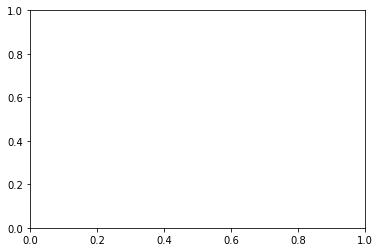

In [325]:
# ******for the vanilla example *******
# visualize each body part on graph original ffn_dlc
fig, ax = plt.subplots()
for col in range(len(testfile.col_names)):
    ax.set_title(testfile.col_names[col])
    ax.set_xlabel('Time in frames (60fps)')
    ax.set_ylabel('Pixle position')
    xdata = np.arange(len(testfile.dlc[:, col]))
    # plot for each model
    for i in range(len(pred_list)):
        ax.plot(xdata, pred_list[i][:, col], label=model_names[i])
    # plot the true dlc
    ax.plot(xdata, testfile.dlc[:, col], label='True DLC')
    ax.legend()
    plt.savefig(plot_dir + f"/{testfile.col_names[col]}.jpg", dpi=150)
    ax.clear()

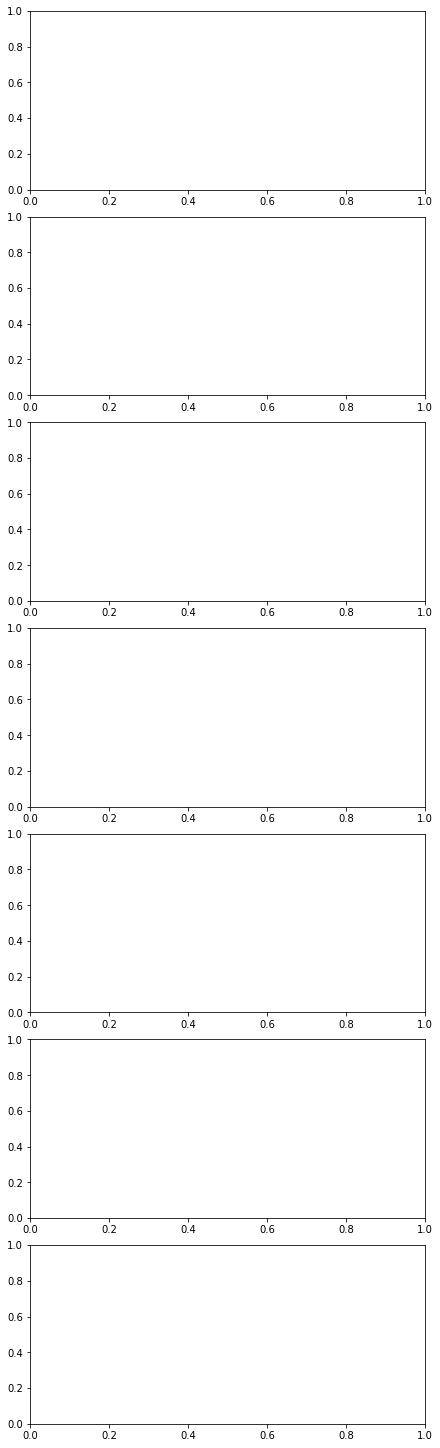

In [339]:
# visualize all together original ffn_dlc
true = testfile.xy
colors = np.array([100, 90, 80, 70, 60, 50, 40, 30, 20, 10, 0])
fig, ax = plt.subplots(figsize=(6,20),nrows=len(pred_list) + 1, layout='constrained')

for frame in range(true.shape[0]):
# for frame in range(1):
    for i in range(len(pred_list)): # each pred model
        pred = pred_xylist[i]
        ax[i].set_title(f'{model_names[i]}')
        ax[i].set_xlim([160, 400])
        ax[i].set_ylim([-300, -80])
        ax[i].scatter(pred[frame, :, 0], -pred[frame, :, 1], c=colors, cmap='plasma')

    # true dlc
    i += 1
    ax[i].set_title('True DLC')
    ax[i].set_xlim([160, 400])
    ax[i].set_ylim([-300, -80])
    ax[i].scatter(true[frame, :, 0], -true[frame, :, 1], c=colors, cmap='plasma')

# plt.savefig(save_dir + "/full_scatter.jpg")
    plt.savefig(save_dir + "/%07d.jpg" % frame)
    for i in range(len(ax)):
        ax[i].clear()

In [479]:
# *******Comparing differnt filters*******
testfile_path = testfiles[1]
# load in testfile
with open(testfile_path, 'rb') as file:
    testfile = pickle.load(file)
# only looking at model2
model_paths = 'speech2ult/predictions/models/dlc_tests'
model_list = glob.glob(model_paths + '/**/model2/*.json')
model_list.remove('speech2ult/predictions/models/dlc_tests/ffn_dlc_w_both/model2/DNN_ffn_dlc_w_both_2022-08-04_model.json')
model_list.remove('speech2ult/predictions/models/dlc_tests/ffn_dlc_w_med/model2/DNN_ffn_dlc_w_med_2022-08-04_model.json')

model_names = [path.lstrip(model_paths).split('/')[0] for path in model_list]
model_type = ['ffn' if 'w' not in model else 'window' for model in model_names]
filter_type = []
for model in model_names:
    if model.endswith('butter'):
        filter_type.append('butter')
    elif model.endswith('med'):
        filter_type.append('median')
    elif model.endswith('both'):
        filter_type.append('both')
    else:
        filter_type.append(None)

pred_list = []
pred_xylist = []

In [480]:
filter = {
    'both': testfile.bothfilt,
    'butter': testfile.butter,
    'median': testfile.medfilt
}

In [481]:
# get acutal scalars
scalars = []
for model in model_list:
    path = os.path.dirname(model)
    model_scalar_path = glob.glob(os.path.join(path, '../data', 'PARAM_DICTS*.pickle'))[0]
    with open(model_scalar_path, 'rb') as file:
        dlc_params, aud_params = pickle.load(file)
    scalars.append(dlc_params['scalar'])

In [390]:
# make predictions
for i, path in enumerate(model_list):
    model = load_model(path)

    if model_type[i] == 'ffn':
        pred_dlc = model.predict(testfile.aud_feat, verbose=0)
    elif model_type[i] == 'window':
        pred_dlc = model.predict(testfile.window, verbose=0)

    # need to use proper scalar
    # pred_dlc = testfile.dlc_scalar.inverse_transform(pred_dlc)
    pred_dlc = scalars[i].inverse_transform(pred_dlc)
    dlc_xy = pred_dlc.reshape((-1, 11, 2))

    pred_list.append(pred_dlc)
    pred_xylist.append(dlc_xy)

ffn_dlc_w
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              201000    
                                                                 
 dense_1 (Dense)             (None, 1000)              1001000   
                                                                 
 dense_2 (Dense)             (None, 1000)              1001000   
                                                                 
 dense_3 (Dense)             (None, 1000)              1001000   
                                                                 
 dense_4 (Dense)             (None, 1000)              1001000   
                                                                 
 dense_5 (Dense)             (None, 22)                22022     
                                                                 
Total params: 4,227,022
Trainable params: 4,22

In [391]:
testfile.xy = testfile.dlc.reshape((-1, 11, 2))
testfile.both_xy = testfile.bothfilt.reshape((-1, 11, 2))
testfile.med_xy = testfile.medfilt.reshape((-1, 11, 2))
testfile.butter_xy = testfile.butter.reshape((-1, 11, 2))

testfile.col_names = ['vallecula_x', 'vallecula_y', 'tongueRoot1_x', 'tongueRoot1_y',
       'tongueRoot2_x', 'tongueRoot2_y', 'tongueBody1_x', 'tongueBody1_y',
       'tongueBody2_x', 'tongueBody2_y', 'tongueDorsum1_x', 'tongueDorsum1_y',
       'tongueDorsum2_x', 'tongueDorsum2_y', 'tongueBlade1_x',
       'tongueBlade1_y', 'tongueBlade2_x', 'tongueBlade2_y', 'tongueTip1_x',
       'tongueTip1_y', 'tongueTip2_x', 'tongueTip2_y']

In [392]:
# set the save dir
save_dir = os.path.join(model_paths, f'pred_{testfile.basename}')
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
plot_dir = os.path.join(save_dir, 'plots')
if not os.path.exists(plot_dir):
    os.mkdir(plot_dir)

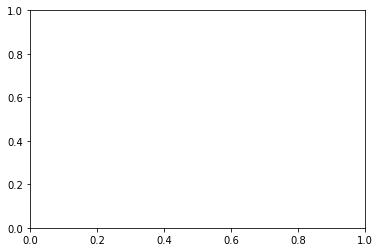

In [393]:
# visualize each body part on graph with filters
fig, ax = plt.subplots()
for col in range(len(testfile.col_names)):
    ax.set_title(testfile.col_names[col])
    ax.set_xlabel('Time in frames (60fps)')
    ax.set_ylabel('Pixle position')
    xdata = np.arange(len(testfile.dlc[:, col]))
    # plot for each model
    for i in range(len(pred_list)):
        ax.plot(xdata, pred_list[i][:, col], label=model_names[i], ls='--', linewidth = 1)
    # plot the true dlc
    ax.plot(xdata, testfile.dlc[:, col], label='True DLC', color='r')

    ax.legend()
    plt.savefig(plot_dir + f"/{testfile.col_names[col]}.jpg", dpi=150)
    ax.clear()

In [398]:
grid = [[model_names[0], model_names[3]],
        [model_names[1], model_names[4]],
        [model_names[2], model_names[5]],
        ['True DLC', 'butter_filter']]

In [395]:
grid_dict = {model_names[i]: pred_xylist[i] for i in range(6)}
grid_dict['butter_filter'] = testfile.butter_xy
grid_dict['True DLC'] = testfile.xy

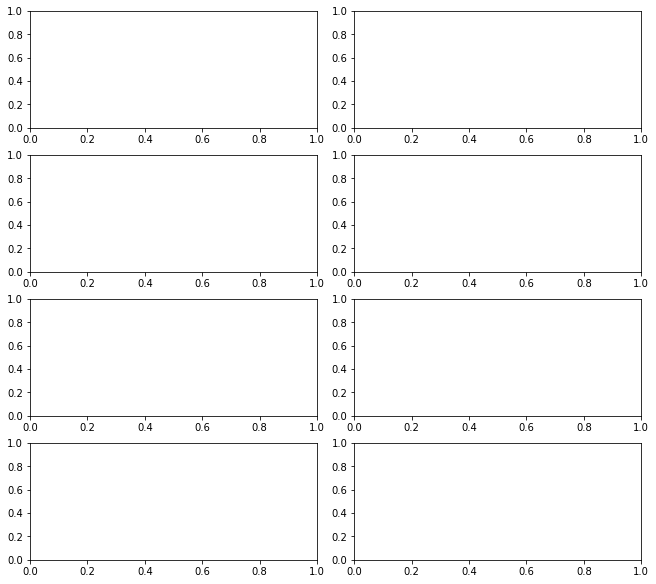

In [407]:
# visualize all together with filter
colors = np.array([100, 90, 80, 70, 60, 50, 40, 30, 20, 10, 0])

fig, ax = plt.subplot_mosaic(grid, figsize=(9,8), layout='constrained')

for frame in range(testfile.dlc.shape[0]):
# for frame in range(7,8):
    for i in ax:
        ax[i].set_title(f'{i}')
        ax[i].set_xlim([130, 430])
        ax[i].set_ylim([-330, -50])
        ax[i].scatter(grid_dict[i][frame, :, 0], -grid_dict[i][frame, :, 1], c=colors, cmap='plasma')

# plt.savefig(save_dir + "/full_scatter.jpg")
    plt.savefig(save_dir + "/%07d.jpg" % frame)
    for i in ax:
        ax[i].clear()
# plt.show()

In [415]:
make_vid(save_dir, f'pred_{testfile.basename}', 'avi')

ffmpeg version 3.2.4 Copyright (c) 2000-2017 the FFmpeg developers
  built with Apple LLVM version 6.1.0 (clang-602.0.53) (based on LLVM 3.6.0svn)
  configuration: --prefix=/Users/travis/miniconda3/conda-bld/ffmpeg_1510333912089/_b_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_pl --disable-doc --enable-shared --enable-static --extra-cflags='-Wall -g -m64 -pipe -O3 -march=x86-64 -fPIC -I/Users/travis/miniconda3/conda-bld/ffmpeg_1510333912089/_b_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_pl/include' --extra-cxxflags='=-Wall -g -m64 -pipe -O3 -march=x86-64 -fPIC' --extra-libs='-L/Users/travis/miniconda3/conda-bld/ffmpeg_1510333912089/_b_env_placehold_placehold_placehold_placehold_placehold_place

In [411]:
# for audio
import soundfile as sf
test_data = 'speech2ult/predictions/test_data'
sf.write(test_data+f'/sync_{testfile.basename}.wav', testfile.wav, testfile.sr)

In [416]:
subprocess.call(
        ["ffmpeg",
         "-i", test_data+f'/sync_{testfile.basename}.wav',
         "-i", save_dir + f'/pred_{testfile.basename}.avi',
         "-codec", "copy", "-shortest", save_dir + "/with_aud.avi"])

ffmpeg version 3.2.4 Copyright (c) 2000-2017 the FFmpeg developers
  built with Apple LLVM version 6.1.0 (clang-602.0.53) (based on LLVM 3.6.0svn)
  configuration: --prefix=/Users/travis/miniconda3/conda-bld/ffmpeg_1510333912089/_b_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_pl --disable-doc --enable-shared --enable-static --extra-cflags='-Wall -g -m64 -pipe -O3 -march=x86-64 -fPIC -I/Users/travis/miniconda3/conda-bld/ffmpeg_1510333912089/_b_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_pl/include' --extra-cxxflags='=-Wall -g -m64 -pipe -O3 -march=x86-64 -fPIC' --extra-libs='-L/Users/travis/miniconda3/conda-bld/ffmpeg_1510333912089/_b_env_placehold_placehold_placehold_placehold_placehold_place

0

In [501]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
#*********DLC2ULt*******************

In [511]:
# need to use differnt scalars for each filter
scalar_dict = {
    'orig': scalars[1],
    'median': scalars[3],
    'butter': scalars[4],
    'both': scalars[5]
}

In [512]:
dlc_input = {
    'both': testfile.bothfilt,
    'butter': testfile.butter,
    'median': testfile.medfilt,
    'orig': testfile.dlc
}

for key in dlc_input:
    dlc_input[key] = scalar_dict[key].transform(dlc_input[key])

In [417]:
#run from here

In [8]:
testfile_path = testfiles[1]
# load in testfile
with open(testfile_path, 'rb') as file:
    testfile = pickle.load(file)
testfile.transform = transfrom(testfile.ult)

In [491]:
model_paths = 'speech2ult/predictions/models/dlc2ult'
model_list = glob.glob(model_paths + '/**/*.json')
model_names = [os.path.basename(os.path.dirname(model)) for model in model_list]

In [531]:
# for each model predict using each filter
pred_list = []
for path in model_list:
    model = load_model(path)
    model_preds = {}

    for key in dlc_input:
        model_preds[key] = model.predict(dlc_input[key], verbose=0)
        model_preds[key] = transfrom(model_preds[key].reshape(-1, 64, 128))

    pred_list.append(model_preds)


In [499]:
save_dir_list = []
for i in range(len(model_list)):
    save_dir = os.path.join(model_paths, model_names[i], f'pred_{testfile.basename}')
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    save_dir_list.append(save_dir)

In [519]:
keys = list(model_preds.keys())
mod = 0

1.2057684659957886

ffmpeg version 3.2.4 Copyright (c) 2000-2017 the FFmpeg developers
  built with Apple LLVM version 6.1.0 (clang-602.0.53) (based on LLVM 3.6.0svn)
  configuration: --prefix=/Users/travis/miniconda3/conda-bld/ffmpeg_1510333912089/_b_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_pl --disable-doc --enable-shared --enable-static --extra-cflags='-Wall -g -m64 -pipe -O3 -march=x86-64 -fPIC -I/Users/travis/miniconda3/conda-bld/ffmpeg_1510333912089/_b_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_pl/include' --extra-cxxflags='=-Wall -g -m64 -pipe -O3 -march=x86-64 -fPIC' --extra-libs='-L/Users/travis/miniconda3/conda-bld/ffmpeg_1510333912089/_b_env_placehold_placehold_placehold_placehold_placehold_place

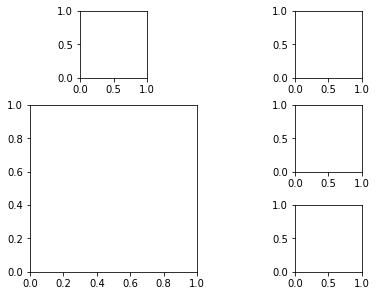

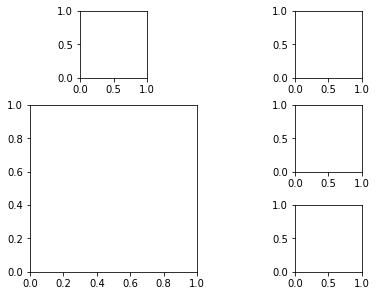

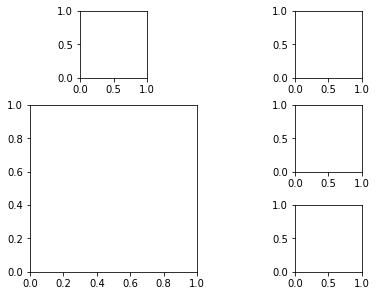

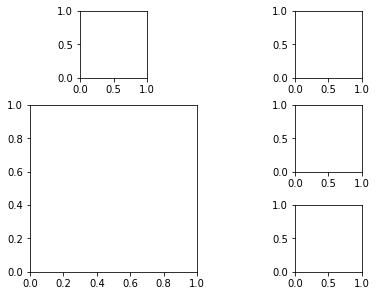

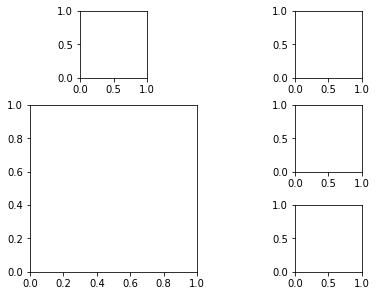

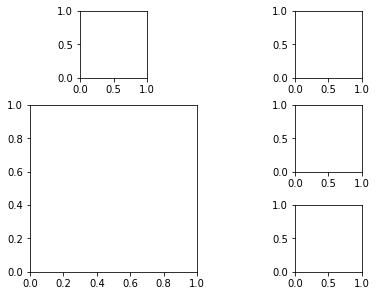

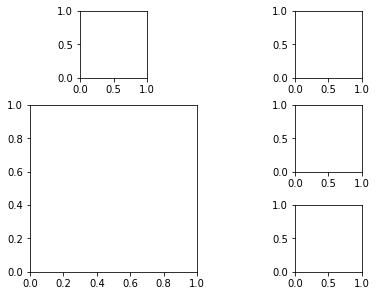

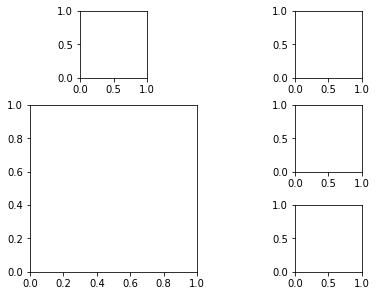

In [534]:
for mod in range(len(model_names)):
    max_true = np.max(testfile.transform)
    # max_pred = np.max(list(pred_list[mod].values()))

    grid = [[keys[0], keys[1]],
            ['True Ult', keys[2]],
            ['True Ult', keys[3]]]
    fig, ax = plt.subplot_mosaic(grid, layout = 'constrained')

    for frame in range(testfile.ult.shape[0]):
    # for frame in range(5):
        for key in keys:
            ax[key].set_title(key)
            ax[key].axis('off')
            ax[key].imshow(pred_list[mod][key][frame].T, aspect='equal', origin='lower', cmap='gray')

        ax['True Ult'].set_title('True Ult')
        ax['True Ult'].axis('off')
        ax['True Ult'].imshow(testfile.transform[frame].T, aspect='equal', origin='lower', cmap='gray')

        plt.savefig(save_dir_list[mod] + "/%07d.jpg" % frame, dpi=150)
        for i in ax:
            ax[i].clear()
    # plt.show()
    make_vid(save_dir_list[mod], f'pred_{model_names[mod]}')


In [13]:
#### for predicted dlc
# load in pickle predictions
dlc2ult_pred_path = 'speech2ult/predictions/dlc2ult_preds.pickle'
with open(dlc2ult_pred_path, 'rb') as file:
    ult_pred_list, scal_pred_list, pred_list_names = pickle.load(file)
# transform each one
pred_test = [transfrom(ult.reshape((-1, 64, 128)) - ult.min()) for ult in scal_pred_list]
pred_list = [transfrom(ult.reshape((-1, 64, 128))) for ult in scal_pred_list]


In [14]:
grid = [['true_ultrasaound', pred_list_names[0], pred_list_names[1]],
        pred_list_names[2:5],
        pred_list_names[5:]]
save_dir = 'speech2ult/predictions/models/dlc2ult/preds'

names = {'true_ultrasaound': 'True Ultrasound',
         pred_list_names[0]: 'Original Model1',
         pred_list_names[1]: 'Original Model2',
         pred_list_names[2]: 'Both Model1',
         pred_list_names[3]: 'Both Model2',
         pred_list_names[4]: 'Butter Model1',
         pred_list_names[5]: 'Butter Model2',
         pred_list_names[6]: 'Median Model1',
         pred_list_names[7]: 'Median Model2',

}

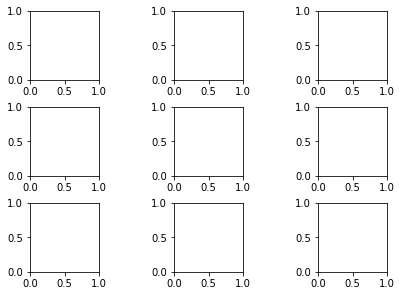

In [15]:
max_true = np.max(testfile.transform)
fig, ax = plt.subplot_mosaic(grid, layout = 'constrained')

for frame in range(testfile.transform.shape[0]):
# for frame in range(1,2):
    for name, ult in zip(pred_list_names, pred_test):
        ax[name].set_title(names[name])
        ax[name].axis('off')
        ax[name].imshow(ult[frame].T, aspect='equal', origin='lower', cmap='gray')

    ax['true_ultrasaound'].set_title('True Ultrasound')
    ax['true_ultrasaound'].axis('off')
    ax['true_ultrasaound'].imshow(testfile.transform[frame].T, aspect='equal', origin='lower', cmap='gray')

    plt.savefig(save_dir + "/%07d.jpg" % frame, dpi=200)
    for i in ax:
        ax[i].clear()
# plt.show()


In [16]:
make_vid(save_dir, f'pred_{testfile.basename}', type='mp4')

ffmpeg version 3.2.4 Copyright (c) 2000-2017 the FFmpeg developers
  built with Apple LLVM version 6.1.0 (clang-602.0.53) (based on LLVM 3.6.0svn)
  configuration: --prefix=/Users/travis/miniconda3/conda-bld/ffmpeg_1510333912089/_b_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_pl --disable-doc --enable-shared --enable-static --extra-cflags='-Wall -g -m64 -pipe -O3 -march=x86-64 -fPIC -I/Users/travis/miniconda3/conda-bld/ffmpeg_1510333912089/_b_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_pl/include' --extra-cxxflags='=-Wall -g -m64 -pipe -O3 -march=x86-64 -fPIC' --extra-libs='-L/Users/travis/miniconda3/conda-bld/ffmpeg_1510333912089/_b_env_placehold_placehold_placehold_placehold_placehold_place

0

In [12]:
testfile.transform = transfrom(testfile.ult + 17)

In [39]:
testfile.transform.min()

0.0